# TKE tidal timeseries

In [63]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline
import mplsettings

print("numpy version  : ", np.__version__)
print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)

numpy version  :  1.23.5
pandas version :  2.0.0
xarray version :  2023.4.2


In [64]:
#sns.set_style('white')
#sns.set_context('paper', font_scale=3)
#sns.set_palette('hls', 6)
#sns.set_style('ticks')

In [65]:
dirstix = "/net2/rnd/dev/stixfonts/fonts/static_ttf"
import matplotlib.font_manager as font_manager
for font in font_manager.findSystemFonts(dirstix):
    font_manager.fontManager.addfont(font)

# Set font family globally
plt.rcParams['font.family'] = 'STIX Two Text'

In [66]:
static_p25  = xr.open_dataset("/net/smg/OWG/CM4_highres/grids/p25/ocean_annual.static.nc")
static_p125 = xr.open_dataset("/net/smg/OWG/CM4_highres/grids/p125/ocean_annual.static.nc")

In [67]:
mask_p25  = static_p25['deptho']/static_p25['deptho']
mask_p125 = static_p125['deptho']/static_p125['deptho']
mask_p25
mask_p125

area_p25  = static_p25['areacello']  * mask_p25
area_p125 = static_p125['areacello'] * mask_p125

In [70]:
dir_odiv209 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual/ts/annual/5yr"
dir_odiv210 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual/ts/annual/5yr"
dir_odiv230 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual/ts/annual/5yr"
dir_odiv231 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual/ts/annual/5yr"
dir_odiv232 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual/ts/annual/5yr"
dir_odiv233 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p125/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual/ts/annual/5yr"
dir_odiv255 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual/ts/annual/5yr"
dir_odiv293 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_ssp585_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual/ts/annual/5yr"
dir_odiv306 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel22-prod-openmp/pp/ocean_annual/ts/annual/5yr"

fname_odiv209 = dir_odiv209+"/ocean_annual.*.TKE_itidal.nc"
fname_odiv210 = dir_odiv210+"/ocean_annual.*.TKE_itidal.nc"
fname_odiv230 = dir_odiv230+"/ocean_annual.*.TKE_itidal.nc"
fname_odiv231 = dir_odiv231+"/ocean_annual.*.TKE_itidal.nc"
fname_odiv232 = dir_odiv232+"/ocean_annual.*.TKE_itidal.nc"
fname_odiv233 = dir_odiv233+"/ocean_annual.*.TKE_itidal.nc"
fname_odiv255 = dir_odiv255+"/ocean_annual.*.TKE_itidal.nc"
fname_odiv293 = dir_odiv293+"/ocean_annual.*.TKE_itidal.nc"
fname_odiv306 = dir_odiv306+"/ocean_annual.*.TKE_itidal.nc"

In [71]:
ds_209 = xr.open_mfdataset(fname_odiv209, decode_times=False, chunks={'time':5})
ds_210 = xr.open_mfdataset(fname_odiv210, decode_times=False, chunks={'time':5})
ds_230 = xr.open_mfdataset(fname_odiv230, decode_times=False, chunks={'time':5})
ds_231 = xr.open_mfdataset(fname_odiv231, decode_times=False, chunks={'time':5})
ds_232 = xr.open_mfdataset(fname_odiv232, decode_times=False, chunks={'time':5})
ds_233 = xr.open_mfdataset(fname_odiv233, decode_times=False, chunks={'time':5})
ds_255 = xr.open_mfdataset(fname_odiv255, decode_times=False, chunks={'time':5})
ds_293 = xr.open_mfdataset(fname_odiv293, decode_times=False, chunks={'time':5})
ds_306 = xr.open_mfdataset(fname_odiv306, decode_times=False, chunks={'time':5})

In [80]:
ds_209['time'] = ds_209['time']/365. + 1750.0
ds_210['time'] = ds_210['time']/365. + 1750.0
ds_230['time'] = ds_230['time']/365. + 1750.0
ds_231['time'] = ds_231['time']/365. + 1850.0
ds_232['time'] = ds_232['time']/365. + 1850.0
ds_233['time'] = ds_233['time']/365. + 1850.0
ds_255['time'] = ds_255['time']/365. + 1850.0
ds_293['time'] = ds_293['time']/365. + 1850.0
#ds_306['time'] = ds_306['time']/365. + 1850.0
ds_306['time'] = ds_306['time']/365.


In [73]:
itidal_wgt_209 = ds_209['TKE_itidal']*area_p125
itidal_wgt_210 = ds_210['TKE_itidal']*area_p25  
itidal_wgt_230 = ds_230['TKE_itidal']*area_p25
itidal_wgt_231 = ds_231['TKE_itidal']*area_p25
itidal_wgt_232 = ds_232['TKE_itidal']*area_p25
itidal_wgt_233 = ds_233['TKE_itidal']*area_p125
itidal_wgt_255 = ds_255['TKE_itidal']*area_p125
itidal_wgt_293 = ds_293['TKE_itidal']*area_p125
itidal_wgt_306 = ds_306['TKE_itidal']*area_p25

In [74]:
TKE_total_209 = itidal_wgt_209.sum(dim=['xh','yh'])/1e12   
TKE_total_210 = itidal_wgt_210.sum(dim=['xh','yh'])/1e12   
TKE_total_230 = itidal_wgt_230.sum(dim=['xh','yh'])/1e12   
TKE_total_231 = itidal_wgt_231.sum(dim=['xh','yh'])/1e12   
TKE_total_232 = itidal_wgt_232.sum(dim=['xh','yh'])/1e12   
TKE_total_233 = itidal_wgt_233.sum(dim=['xh','yh'])/1e12  
TKE_total_255 = itidal_wgt_255.sum(dim=['xh','yh'])/1e12   
TKE_total_293 = itidal_wgt_293.sum(dim=['xh','yh'])/1e12   
TKE_total_306 = itidal_wgt_306.sum(dim=['xh','yh'])/1e12   

In [75]:
#TKE_total_209.to_netcdf('TKE_total_209.nc', mode='w')
#TKE_total_210.to_netcdf('TKE_total_210.nc', mode='w')
#TKE_total_230.to_netcdf('TKE_total_230.nc', mode='w')
#TKE_total_231.to_netcdf('TKE_total_231.nc', mode='w')
#TKE_total_232.to_netcdf('TKE_total_232.nc', mode='w')
#TKE_total_233.to_netcdf('TKE_total_233.nc', mode='w')
#TKE_total_255.to_netcdf('TKE_total_255.nc', mode='w')

In [78]:
TKE_total_209.load()
TKE_total_210.load()
TKE_total_230.load()
TKE_total_231.load()
TKE_total_232.load()
TKE_total_233.load()
TKE_total_255.load()
TKE_total_293.load()
TKE_total_306.load()

<xarray.DataArray (time: 245)>
array([1.1543305, 1.155213 , 1.1547446, 1.1541488, 1.1544856, 1.1552819,
       1.1546631, 1.1545852, 1.1555312, 1.155948 , 1.1536461, 1.152777 ,
       1.1538253, 1.1547099, 1.1537437, 1.1544129, 1.1551063, 1.1557248,
       1.155717 , 1.1574804, 1.1563627, 1.1560938, 1.1572003, 1.1586573,
       1.1568861, 1.1575067, 1.1573814, 1.1563638, 1.1555481, 1.1589155,
       1.1582289, 1.1572294, 1.1587961, 1.1581743, 1.1569877, 1.1572824,
       1.1572275, 1.1568336, 1.1573311, 1.1584504, 1.1587697, 1.157361 ,
       1.1587154, 1.1583194, 1.1600113, 1.1582524, 1.1614933, 1.16161  ,
       1.1599624, 1.1599613, 1.158389 , 1.1588753, 1.1578469, 1.1605853,
       1.1613135, 1.1598567, 1.1578417, 1.1573284, 1.1582179, 1.156722 ,
       1.1579794, 1.1564151, 1.1585546, 1.1579758, 1.157472 , 1.1565403,
       1.1565083, 1.1574692, 1.1561817, 1.1546612, 1.1557647, 1.1583234,
       1.1583961, 1.1564283, 1.1574075, 1.1571517, 1.1574183, 1.1581981,
       1.1580292, 1.1561655, 1.156951 , 1.1590046, 1.1576325, 1.1592292,
       1.1573596, 1.1563562, 1.158309 , 1.1595231, 1.1582584, 1.1562331,
       1.1580092, 1.1571726, 1.1561689, 1.1561521, 1.1549635, 1.1569225,
       1.1573006, 1.1559876, 1.1569527, 1.15679  , 1.1580602, 1.1573893,
       1.1567672, 1.1568582, 1.1570293, 1.1571208, 1.1559935, 1.1578841,
       1.1590544, 1.1594096, 1.1581427, 1.1557933, 1.1574514, 1.1579576,
       1.159227 , 1.159748 , 1.1571045, 1.1589483, 1.1602228, 1.1598805,
...
       1.1605906, 1.1588831, 1.1597887, 1.1605326, 1.1583166, 1.1580358,
       1.1576043, 1.1562852, 1.1574984, 1.1575537, 1.1581404, 1.157284 ,
       1.1561861, 1.1571093, 1.1582457, 1.1589581, 1.1574408, 1.1597227,
       1.1603993, 1.1611809, 1.1599609, 1.1592478, 1.1589656, 1.1593585,
       1.1587992, 1.1604896, 1.1592295, 1.1580514, 1.1579295, 1.1587483,
       1.1612294, 1.1589104, 1.1597065, 1.1590312, 1.1622728, 1.1610296,
       1.1614137, 1.1610682, 1.1621469, 1.160637 , 1.1605413, 1.1620548,
       1.1644849, 1.16319  , 1.1629176, 1.1618696, 1.1620979, 1.1615089,
       1.1602196, 1.161887 , 1.1610222, 1.1624442, 1.1628072, 1.1635879,
       1.1621355, 1.1604052, 1.1618801, 1.1613674, 1.1628156, 1.1609894,
       1.1605098, 1.1618558, 1.1607181, 1.160584 , 1.1639733, 1.1631457,
       1.1615429, 1.1634657, 1.1630458, 1.1626663, 1.1613023, 1.1605638,
       1.1627154, 1.160075 , 1.159836 , 1.1604091, 1.1602093, 1.1578603,
       1.1592149, 1.1612059, 1.1610297, 1.1586325, 1.1607754, 1.160709 ,
       1.1582141, 1.1584729, 1.1574367, 1.15891  , 1.1579776, 1.1556113,
       1.1605023, 1.1603829, 1.158827 , 1.1586574, 1.1565907, 1.155338 ,
       1.1588569, 1.1568779, 1.1590486, 1.1564138, 1.1579468, 1.1547624,
       1.1531364, 1.1540382, 1.1535298, 1.1550283, 1.1524253, 1.153022 ,
       1.1564884, 1.1565388, 1.1560792, 1.154715 , 1.1537368],
      dtype=float32)
Coordinates:
  * time     (time) float64 2.21e+03 2.212e+03 2.212e+03 ... 2.454e+03 2.454e+03

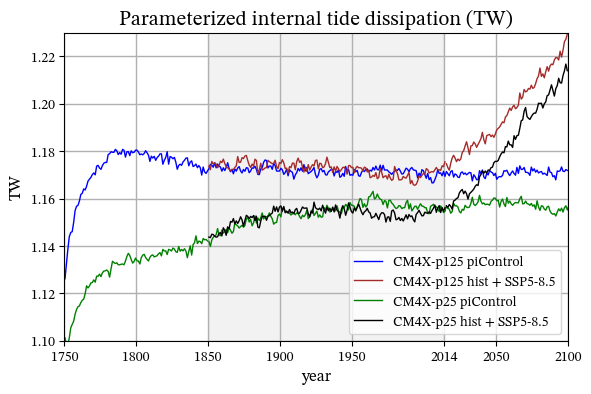

In [84]:
fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(6.5,4.0))

#time_209 = np.arange(len(ds_209.time))
#time_210 = np.arange(len(ds_210.time))
#time_230 = np.arange(len(ds_230.time))

#plt.plot(TKE_total_209.values,label="OM4p125",linewidth=4,linestyle='solid',color='blue')
#plt.plot(TKE_total_210.values,label="OM4p25",linewidth=4,linestyle='solid',color='green')
#plt.plot(TKE_total_230.values,label="OM4p25",linewidth=4,linestyle='solid',color='brown')

TKE_total_210[0:100].plot.line(ax=axis           ,linestyle='solid', color='green', linewidth=1) 

TKE_total_209.plot.line(ax=axis,label='CM4X-p125 piControl',linestyle='solid', color='blue',  linewidth=1) 
###TKE_total_233.plot.line(ax=axis,label='CM4X-p125 hist + SSP5-8.5' ,linestyle='solid', color='brown',   linewidth=1) 
TKE_total_255.plot.line(ax=axis,label='CM4X-p125 hist + SSP5-8.5' ,linestyle='solid', color='brown',   linewidth=1) 
TKE_total_293.plot.line(ax=axis,linestyle='solid', color='brown',   linewidth=1) 

TKE_total_230.plot.line(ax=axis,label='CM4X-p25 piControl' ,linestyle='solid', color='green', linewidth=1) 
TKE_total_306.plot.line(ax=axis,linestyle='solid', color='green', linewidth=1) 
TKE_total_231.plot.line(ax=axis,label='CM4X-p25 hist + SSP5-8.5' ,linestyle='solid', color='black', linewidth=1) 
TKE_total_232.plot.line(ax=axis,linestyle='solid', color='black',   linewidth=1) 

axis.legend(loc='lower right')
axis.set_ylabel('TW',fontsize=12)
axis.set_xlabel('year',fontsize=12)
axis.grid(linewidth=1)
axis.set_xlim(1750, 2100)
plt.xticks(ticks=[1750, 1800, 1850, 1900, 1950, 2014, 2050, 2100])
axis.set_ylim(1.10,1.23)


#axis.axvline(x=2014, color='r', linestyle='-',linewidth=2)
axis.fill_between(TKE_total_230['time'].values, 1.10, TKE_total_230['time'].values,
                  where=((TKE_total_230['time'] >= 1850) & (TKE_total_230['time'] <= 2014)),
                  interpolate=True, color='gray', alpha=0.1)

axis.set_title('Parameterized internal tide dissipation (TW)',fontsize=15)
fig.savefig('TKE_itidal.jpg', bbox_inches='tight', dpi=400, format='jpeg')
